In [385]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import random as rd

In [386]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [387]:
def align_images(images, num_bits):
    num_images = len(images)
    gray_images = []
    for i in range(num_images):
        gray_images.append(cv.cvtColor(images[i], cv.COLOR_BGR2GRAY))
        
    # Compute median threshold bitmap
    median_image = np.median(gray_images, axis=0).astype(np.uint8)
    bitmap_images = []
    for i in range(num_images):
        bitmap_images.append((gray_images[i] > median_image).astype(np.uint8))
        
    # Compute shift matrices using bitmap images
    shift_matrices = []
    for i in range(num_images):
        shift_matrices.append(np.zeros((2,3), dtype=np.float32))
    for bit in range(num_bits):
        for i in range(num_images):
            if bit == 0:
                continue
            prev_bitmap = bitmap_images[i-1]
            curr_bitmap = bitmap_images[i]
            diff = curr_bitmap.astype(np.int16) - prev_bitmap.astype(np.int16)
            shift = np.zeros((2,), dtype=np.float32)
            for y in range(diff.shape[0]):
                for x in range(diff.shape[1]):
                    if diff[y,x] == 1:
                        shift[1] += y
                        shift[0] += x
                    elif diff[y,x] == -1:
                        shift[1] -= y
                        shift[0] -= x
            shift /= np.sum(np.abs(shift))
            shift_matrices[i][:,2] += (2**bit) * shift
        
    # Apply shift matrices to images
    aligned_images = []
    for i in range(num_images):
        aligned_images.append(cv.warpAffine(images[i], shift_matrices[i], 
                                              gray_images[i].shape[::-1], 
                                              flags=cv.INTER_LINEAR))
    return aligned_images

In [388]:
def sample_pixels(images, num_samples):
    
    # Choose pixels with largest standard deviation
    stds = np.std(images, axis=0)
    selected_pixel_value = np.argsort(stds.ravel())[::-1][:num_samples]
    sampled_pixels = np.unravel_index(selected_pixel_value, stds.shape) 
    # returns (i of chosen pixels, j of chosen pixels)
    
    # Compute the sample values for each pixel
    samples = np.zeros((num_samples, len(images)), dtype=np.float32)
    for i in range(num_samples):
        x, y = sampled_pixels[0][i], sampled_pixels[1][i]
        for j in range(len(images)):
            samples[i, j] = images[j][x, y]
    
    return samples






    # returns [ [first chosen pixel in every image], [], ..... [] ]
# def sample_pixels(images, num_samples):
    
#     # Divide the image into 100x100 areas
#     step = 100
#     x_starts = np.arange(0, images[0].shape[0], step)
#     y_starts = np.arange(0, images[0].shape[1], step)
    
#     # Choose pixels with largest standard deviation in each area
#     sampled_pixels = []
#     for x in x_starts:
#         for y in y_starts:
#             x_end = min(x+step, images[0].shape[0])
#             y_end = min(y+step, images[0].shape[1])
#             subimages = [img[x:x_end, y:y_end] for img in images]
#             stds = np.std(subimages, axis=0)
#             max_idx = np.argmax(stds)
#             max_pos = np.unravel_index(max_idx, stds.shape)
#             sampled_pixels.append((x+max_pos[0], y+max_pos[1]))
            
#             if len(sampled_pixels) == num_samples:
#                 break
                
#         if len(sampled_pixels) == num_samples:
#             break
    
#     # Compute the sample values for each pixel
#     samples = np.zeros((num_samples, len(images)), dtype=np.float32)
#     for i, pixel_pos in enumerate(sampled_pixels):
#         x, y = pixel_pos
#         for j in range(len(images)):
#             samples[i, j] = images[j][x, y]
    
#     return samples


In [389]:
def solve_respond_curve(z,lgT,lam,w):
    #z : ith pixel of those chosen in jth image
    n = len(z) #n : we choose n pixels total for each images
    p = len(z[0])#p : we choose p images total 
    row = n*p + 1 + 254
    col = 256 + n   # row and col in matrix a
    a = [[] for i in range(row)]
    b = [[] for i in range(row)]

    #initialize matrix a(zero) and b(zero)
    for i in range(row):
        b[i].append(0)
        for j in range(col):
            a[i].append(0)

    #upper half of matrix a and b done
    for j in range(p):
        for i in range(n):
            Z = int(z[i][j])
            b[i+j*n][0] = lgT[j] * w[Z]
            for r in range(256):
                if r == Z :
                    a[i+j*n][r] = 1 * w[Z]
            a[i+j*n][i] = -1 * w[Z]

    #fix the curve by setting its middle value to 0
    a[n*p][128] = 1

    #lower half of matrix a and b done
    for k in range(n*p+1,n*p+255):
        for l in range(255):
            a[k][l] = 1 * w[l+1] * lam 
            a[k][l+1] = -2 * w[l+1] * lam 
            a[k][l+2] = 1 * w[l+1] * lam 
            
    
    A = np.array(a)
    B = np.array(b)

    #Solve the system using SVD
    x = np.linalg.lstsq(A,B)[0]
    g = x[:256]
    lE = x[256:]
    
    return g, lE

In [390]:
def construct_hdr(w,z,g,lgt): 
    p = len(z) #p : we choose p images total 
    N = len(z[0])#N : total N pixels for each images
    lnE = [0]*N#initial lnEi
    E = [0]*N
    
    for i in range(N):
        top = 0 #each i 分子 initial
        bottom = 0 #each i 分母 initial
        for j in range(p):
            Z = z[j][i]
            top += w[Z]*(g[Z]-lgt[j])
            bottom += w[Z]
        
        lnE[i] = (top/bottom)[0] if bottom > 0 else top
        E[i] = math.exp(lnE[i])
    #print(lnE)
    return E


In [391]:
def show_false_color(images, gb, gg, gr, exposure_times):
    # Construct radiance map for each channels
    p = len(images) #how many images total
    height = len(images[0]) #height and width, should be same for eahc image
    width = len(images[0][0])
    hdr = np.zeros((height, width, 3),'float32') #real exposure array, 3 channel for all images
    ln_t = np.log2(exposure_times)
    w = [z if z <= 0.5*255 else 255-z for z in range(256)]


    #real exposure mapping of channel B for all images
    Zb = [[] for i in range(p)]
    Zb = [img[...,0].flatten().tolist() for img in images]
    Eb = construct_hdr(w,Zb,gb,ln_t)
    hdr[...,0] = np.reshape(Eb, (height,width))
    #print(hdr[...,0])
    
    #real exposure mapping of channel G for all images
    Zg = [[] for i in range(p)]
    Zg = [img[...,1].flatten().tolist() for img in images]
    Eg = construct_hdr(w,Zg,gg,ln_t)
    hdr[...,1] = np.reshape(Eg, (height,width))
    #print(hdr[...,1])


    #real exposure mapping of channel R for all images
    Zr = [[] for i in range(p)]
    Zr = [img[...,2].flatten().tolist() for img in images]
    Er = construct_hdr(w,Zr,gr,ln_t)
    hdr[...,2] = np.reshape(Er, (height,width))
    #print(hdr[...,2])




    #img_size = img_list[0][0].shape
    
    #ln_t = np.log2(exposure_times)

    #vfunc = np.vectorize(lambda x:math.exp(x))
    #hdr = np.zeros((img_size[0], img_size[1], 3), 'float32')

    # construct radiance map for BGR channels
    #for i in range(3):
    #    print(' - Constructing radiance map for {0} channel .... '.format('BGR'[i]), end='', flush=True)
    #    Z = [img.flatten().tolist() for img in img_list[i]]
    #    E = construct_radiance_map(response_curve[i], Z, ln_t, w)
    #    # Exponational each channels and reshape to 2D-matrix
    #    hdr[..., i] = np.reshape(vfunc(E), img_size)
    #    print('done')

    # Display Radiance map with pseudo-color image (normal value from fusion of 3 channel of ln exposure)
    # print('Saving pseudo-color radiance map .... ', end='')
    # plt.figure(figsize=(12,8))
    # plt.imshow(cv.cvtColor(hdr, cv.COLOR_BGR2GRAY), cmap='viridis')
    # plt.colorbar()
    # plt.savefig('radiance-map.png')
    # print('done')

    # color_map = plt.get_cmap('plasma')
    # rgb_map = color_map(hdr)
    # pseudo_color_image = (rgb_map[:, :, :3] * 255).astype(np.uint8)
    # cv.imshow('Pseudo-color Radiance Map', pseudo_color_image)

    cmap = plt.cm.get_cmap('jet')
    max_val = np.max(hdr, axis=(0, 1))
    min_val = np.min(hdr, axis=(0, 1))
    hdr_norm = (hdr - min_val) / (max_val - min_val)
    plt.imshow(hdr_norm, cmap=cmap)
    plt.axis('off')
    plt.show()

    

/var/folders/bz/qpg9g_nj7lx_0r49_7jyc15c0000gp/T/ipykernel_1344/1254101073.py:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A,B)[0]


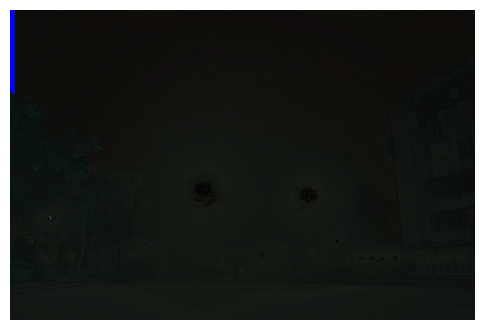

In [392]:
if __name__ == '__main__':
    folder = "testing_image" # for now
    images = load_images(folder)
    images = np.array(images)
    #aligned_images = np.array(align_images(images, 3))
    num_samples = 500 # for now

    z0 = sample_pixels(images[:,:,:,0], num_samples)
    z1 = sample_pixels(images[:,:,:,1], num_samples)
    z2 = sample_pixels(images[:,:,:,2], num_samples)
    #z0 = sample_pixels(aligned_images[:,:,:,0], num_samples)
    #z1 = sample_pixels(aligned_images[:,:,:,1], num_samples)
    #z2 = sample_pixels(aligned_images[:,:,:,2], num_samples)
    
    exposure_times = [1, 1/1.6, 1/2.5, 1/4, 1/6, 1/10, 1/15, 1/25, 1/40, 1/50] # for now
    lambda_ = 50 # for now
    w = [value if value <= 0.5*255 else 255-value for value in range(256)]
    
    gB, _ = solve_respond_curve(z0, exposure_times, lambda_, w)
    gG, _ = solve_respond_curve(z1, exposure_times, lambda_, w)
    gR, _ = solve_respond_curve(z2, exposure_times, lambda_, w)
    
    

    plt.figure(figsize=(6, 6))
    plt.plot(gR, range(256), 'rx')
    plt.plot(gG, range(256), 'gx')
    plt.plot(gB, range(256), 'bx')
    plt.ylabel('pixel value Z')
    plt.xlabel('log exposure X')
    
    show_false_color(images, gB, gG, gR, exposure_times)
    
    
    
    